# Multiscale Intermediate Tutorial
*By R. Bulanadi, 28/01/20*

***
This is the intermediate tutorial for Project Multiscale is currently very powerful. I strongly encourage you to look through the basic tutorial first, since what has been covered there will be assumed.

In this notebook, we will again binarise the Phase channels of the microscopy data obtained from Cypher Asylum AFM. This time, however, we will be operating on four samples, and first applying distortion correction algorithms to this dataset.

As before, we will load the Multiscale package. Make sure you change the directory to your Project Multiscale location.

In [1]:
#import sys
#sys.path.insert(0, '/Users/ralph/Code/Project_Multiscale/') #Change to your Multiscale Directory
from multiscale.processing import twodim
from multiscale.processing import deprecated
from multiscale.processing import core as pt
from multiscale.processing import plot as msplt
import multiscale.io

Matplotlib_scalebar was not found, please install the package.


This example also needs the `glob` package to find the filelist. We now find the filelist, and also declare the filename for the final `.hdf5` file.

In [2]:
from glob import glob

filelist = sorted(glob('*.ibw'))
filename = 'SD_P5_zB4_050mV.hdf5'

We will now convert our raw data (`.ibw` formats) into the `.hdf5` format used by Project Multiscale. By using the function `multiscale.io.read_file.merge_hdf5` (as opposed to `tohdf5` used earlier), we can combine all four of our `.ibw` files into a single `.hdf5` file. This vastly increases the ease of processing, and keeps all the data in the same place.

In [3]:
multiscale.io.read_file.merge_hdf5(filelist, filename.split('.')[0])

file successfully converted
'SD_P4_zB5_050mV_-2550mV_0002.hdf5' successfully merged
file successfully converted
'SD_P4_zB5_050mV_-2650mV_0006.hdf5' successfully merged
file successfully converted
'SD_P4_zB5_050mV_-2800mV_0012.hdf5' successfully merged
file successfully converted
'SD_P4_zB5_050mV_-2950mV_0018.hdf5' successfully merged
4/4 files merged into 'SD_P5_zB4_050mV.hdf5'


In this tutorial, I would also like to call your attention to attributes. Attributes are additional data stored in a dataset that are generated by our functions. Attributes include things like dimensional units, scan shape, or peak positions. In this tutorial, we will use some of these attributes.

***

We can now begin processing. While ideally we could use `m_apply` (or similar) as in the previous tutorial, some functions are sufficiently complicated that they have been hardcoded. They thus must be called directly from the twodim subsections. `twodim.distortion_params_` is one such example. This function is called in the format:

`distortion_params_(filename, all_input_criteria, speed = 2, read_offset = False, cumulative = False)`

The first argument of is the name of the `.hdf5` file, which has already been declared.

To obtain the distortion parameters, we want to pass in the Height channel data to the `twodim.distortion_params_` function. A first thought could be that this could be the full list of all Height data:

`[datasets/SD_P4_zB5_050mV_-2550mV_0002/HeightRetrace, datasets/SD_P4_zB5_050mV_-2650mV_0006/HeightRetrace, datasets/SD_P4_zB5_050mV_-2800mV_0012/HeightRetrace, datasets/SD_P4_zB5_050mV_-2950mV_0018/HeightRetrace]`

But this is quite unwieldy. Rather, many functions, including `twodim.distortion_params_`, `twodim.distortion_correction_`, and `pt.l_apply` all contain a search function to find the list of all necessary paths. In this case, we can use wildcards and pass in `'datasets*Height*'`; the four paths above all qualify with these wildcards. 

`speed` and `read_offset` are additional arguments that help alter the accuracy and speed of the distortion parameter search (`speed` goes up to 4, with higher numbers faster but less accurate; `read_offset` helps increase the accuracy of scans if minor movements are performed in the Cypher AFM software). `cumulative` sets whether distortion correction is made in comparison to the previous scan (default, `False`), or the first scan (`True`).

The function can be called thus:

In [4]:
deprecated.distortion_params_classic(filename, 'datasets*Height*', speed = 1)

distortion_params: 1 of 4 Complete. 0s remaining. datasets/SD_P4_zB5_050mV_-2550mV_0002/HeightRetrace
---
Currently reading path datasets/SD_P4_zB5_050mV_-2650mV_0006/HeightRetrace
Scan 1 Complete. Cumulative Transform Matrix:
[[ 1.        0.       61.16082 ]
 [ 0.        1.       34.615753]]
distortion_params: 2 of 4 Complete. 3s remaining. datasets/SD_P4_zB5_050mV_-2650mV_0006/HeightRetrace
---
Currently reading path datasets/SD_P4_zB5_050mV_-2800mV_0012/HeightRetrace
Scan 2 Complete. Cumulative Transform Matrix:
[[  1.         0.       116.67407 ]
 [  0.         1.        60.933975]]
distortion_params: 3 of 4 Complete. 2s remaining. datasets/SD_P4_zB5_050mV_-2800mV_0012/HeightRetrace
---
Currently reading path datasets/SD_P4_zB5_050mV_-2950mV_0018/HeightRetrace
Scan 3 Complete. Cumulative Transform Matrix:
[[  1.        0.      139.29404]
 [  0.        1.       68.59156]]
distortion_params complete at 12:35! 4 processes performed in 8s.                                               

In addition to the use case above, we can also place the search criteria in a list, where all criteria will be checked. That is, if we set the argument to be `['datasets*Height*', 'datasets*Amplitude*']`, we would use lists generated by both `'datasets*Height*'` and `'datasets*Amplitude*'`.

Note: `'datasets*Height*'` is equivalent to both `['datasets*Height*']` and `[['datasets*Height*']]`. This is the maximum amount of square brackets permitted.

***

We now have parameters for distortion correction in `process/001-distortion_params/`. If we want to apply this distortion correction, we thus need to call the hardcoded function `twodim.distortion_correction_`. Again, this needs to pass in the filename, but it now needs two list paths; one for the raw images that must be corrected, and the other for the parameters used to do the correction.

If we want to correct all the raw images, we can simply search with the string `'datasets*'`. Meanwhile, the distortion parameters can be found in the `process/001-distortion_params/` folder, and thus we can search for `'process/001-distortion_params/*'`.

To separate the two types of data passed in (the images to be corrected, and the parameters used for correction), we separate them out by square brackets and place them in a list. That is, the argument is now `[['datasets*'],['process/001-distortion_params/*']]`, where `['datasets*']` indicates the paths to the raw data, and `['process/001-distortion_params/*']` indicates the paths to the distortion params. Note that, again, we can place additional search criteria in the innermost brackets if needed.

`cropping` is an optional argument that, if set to `True`, crops the dataset to show only the common area. Otherwise, the datasize would extend to show all area seen in any scan.

The function call is now thus:

In [5]:
twodim.distortion_correction_classic(filename, [['datasets*'],['process/001-distortion_params/*']], cropping = True)

distortion_correction complete at 12:35! 32 processes performed in 0s.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Now, let's save images to make sure that the distortion correction worked properly. In the previous tutorial, we used `pt.m_apply`; this time, however, since we are using multiple images, we will instead use `pt.l_apply`.

`pt.l_apply` is effectively a header function that calls `pt.m_apply` multiple times, with several other options to make it efficient for the user. In particular, `pt.l_apply` lets us use the path search, and thus we do not need to explicitly call each path.

We are also adding an additional argument `use_attrs`. This is an argument for both `m_apply` and `l_apply`, which directs it to pass attributes into the function call (in this case, `twodim.save_image`). Because `twodim.save_image` now knows the path, it can automatically generate the filenames. This is one example of the use of attributes.

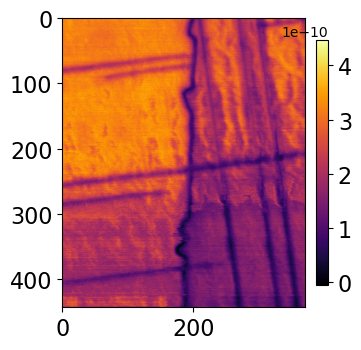

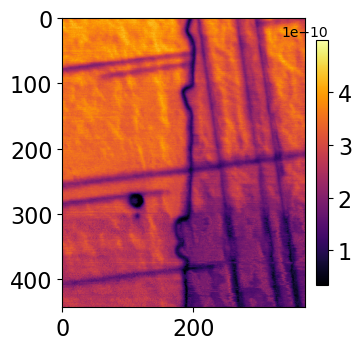

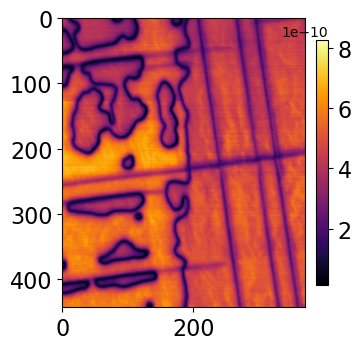

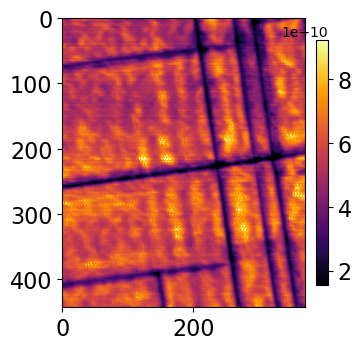

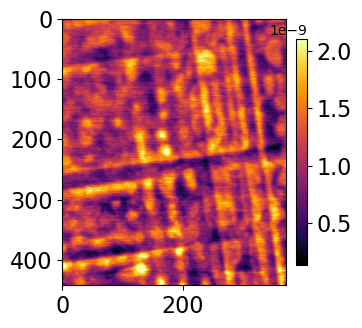

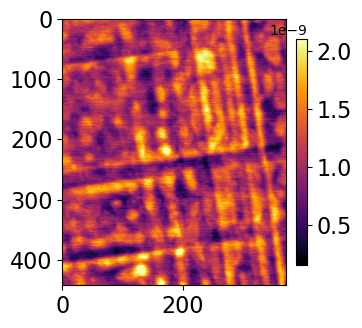

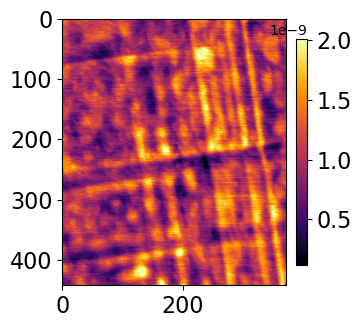

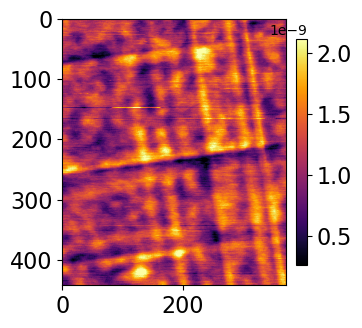

save_image complete at 12:35! 8 processes performed in 1s.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [6]:
pt.l_apply(filename, msplt.save_image, ['process/002*Amplitude1*', 'process/002*Height*'], use_attrs = 'path', show = True)

During the phase linearisation step, we will also set another variable in `l_apply` (which is also in `m_apply`). `prop_attrs` simply copies attributes over from the source files to the destination files. We will be using this value later on, so we will need to propagate it every step of the way.

Instead of operating on only one Phase image of one scan, we are also going to operate on all four Phase data arrays (`Phase1Trace`, `Phase1Retrace`, `Phase2Trace`, and `Phase2Retrace`). Luckily, `l_apply` makes this straightforward.

We're also going to make sure that the function knows that the right side of the image is background, and thus we are adding another argument, `background=-20`.

In [7]:
pt.l_apply(filename, twodim.phase_linearisation, [['process/002*Phase*']], background=-20, phase_range=360, prop_attrs = 'scale_m_per_px', )

phase_linearisation complete at 12:35! 16 processes performed in 7s.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

We are now going to add each the four Phase arrays of a scan together, so we can average out any noise. Recall how we passed two lists of data to `twodim.distortion_correction_`; we are going to do the same again. In this case, we will add the argument:

`[['process/003*Phase1T*'], ['process/003*Phase1R*'], ['process/003*Phase2T*'], ['process/003*Phase2R*']]`

This may be a bit confusing. Remember that the the first list, `['process/003*Phase1T*']`, will cause Python to pass the list:

`[process/003-phase_linearisation/SD_P4_zB5_050mV_-2550mV_0002/Phase1Trace,
process/003-phase_linearisation/SD_P4_zB5_050mV_-2650mV_0006/Phase1Trace,
process/003-phase_linearisation/SD_P4_zB5_050mV_-2800mV_0012/Phase1Trace,
process/003-phase_linearisation/SD_P4_zB5_050mV_-2950mV_0018/Phase1Trace]`

The second and successive lists are:

`[process/003-phase_linearisation/SD_P4_zB5_050mV_-2550mV_0002/Phase1Retrace,
process/003-phase_linearisation/SD_P4_zB5_050mV_-2650mV_0006/Phase1Retrace,
process/003-phase_linearisation/SD_P4_zB5_050mV_-2800mV_0012/Phase1Retrace,
process/003-phase_linearisation/SD_P4_zB5_050mV_-2950mV_0018/Phase1Retrace]`

`[process/003-phase_linearisation/SD_P4_zB5_050mV_-2550mV_0002/Phase2Trace,
process/003-phase_linearisation/SD_P4_zB5_050mV_-2650mV_0006/Phase2Trace,
process/003-phase_linearisation/SD_P4_zB5_050mV_-2800mV_0012/Phase2Trace,
process/003-phase_linearisation/SD_P4_zB5_050mV_-2950mV_0018/Phase2Trace]`

`[process/003-phase_linearisation/SD_P4_zB5_050mV_-2550mV_0002/Phase2Retrace,
process/003-phase_linearisation/SD_P4_zB5_050mV_-2650mV_0006/Phase2Retrace,
process/003-phase_linearisation/SD_P4_zB5_050mV_-2800mV_0012/Phase2Retrace,
process/003-phase_linearisation/SD_P4_zB5_050mV_-2950mV_0018/Phase2Retrace]`

Multiscale will then add the first entry of the first list, to the first entry of the second list, with the first entry of the third list, and the first entry of the fourth list. It will then do the same to all the second entries, and in all the third entries. 

In other words, we are, as we desired, adding all the four Phases for each scan together.

If we want to do the opposite - that is, we want to add the the all the `Phase1Trace`s of all the scans to one another, and all the `Phase1Retrace`s of all the scans and so on, the argument we would pass would instead be:

`[['process/003*SD_P4_zB5_050mV_-2550mV_0002*'], ['process/003*SD_P4_zB5_050mV_-2650mV_0006*'], ['process/003*SD_P4_zB5_050mV_-2800mV_0012*'], ['process/003*SD_P4_zB5_050mV_-2950mV_0018*']]`

In [8]:
pt.l_apply(filename, twodim.m_sum, [['process/003*Phase1T*'], ['process/003*Phase1R*'], ['process/003*Phase2T*'], ['process/003*Phase2R*']], prop_attrs = 'scale_m_per_px', output_names = 'SummedPhase')

m_sum complete at 12:35! 4 processes performed in 0s.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

We can now finally run `twodim.phase_binarisation` on the summed arrays. Note we are again using an attribute, `input_count`, which was made by `twodim.m_sum`. Note that `'scale (m/px)'`

In [9]:
pt.l_apply(filename, twodim.phase_binarisation, 'process/004*', use_attrs = 'input_count', prop_attrs = 'scale_m_per_px', output_names = 'BinarisedPhase')

phase_binarisation complete at 12:35! 4 processes performed in 1s.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

Finally, we are going to save all the binarised phase images. We will again use `twodim.l_apply` on `twodim.save_image`, but this time we are going to pass an additional attribute. The `'scale_m_per_px'` attribute we propagated is now going to be used to generate a scalebar in the final image, in addition to the previously used `'path'` attribute. We are also adding in additional arguments for the sake of appearance. 

Scalebar package is not installed, please install it if you want to add a scalebar to your image


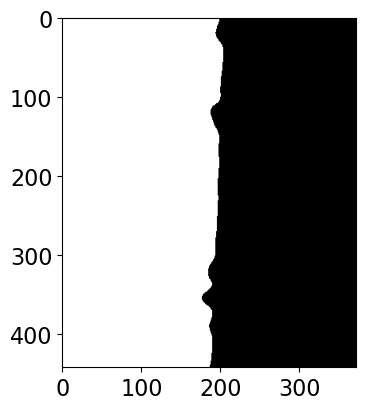

Scalebar package is not installed, please install it if you want to add a scalebar to your image


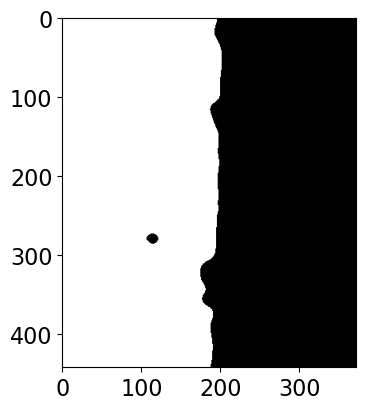

Scalebar package is not installed, please install it if you want to add a scalebar to your image


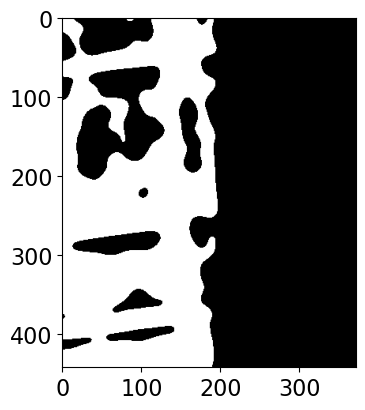

Scalebar package is not installed, please install it if you want to add a scalebar to your image


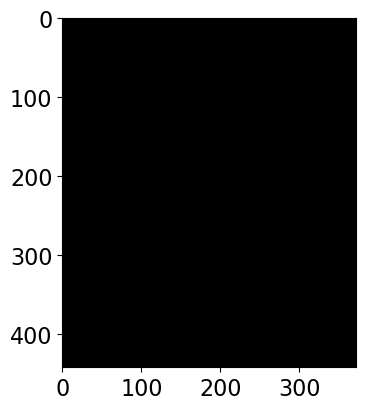

save_image complete at 12:35! 4 processes performed in 0s.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [10]:
pt.l_apply(filename, msplt.save_image, ['process/005*'], use_attrs = ['path', 'scale_m_per_px'], show = True, scalebar=True, colorbar = False, full_range=True, colorm='binary_r')

***

Thus ends the intermediate tutorial for Project Multiscale. This shows how the ability to operate on multiple folders or experiments, and the utilisation of attributes, allows for more powerful functions to be used much more easily than when operating directly on arrays. Like before, each intermediate step is still accessible as well.

If you would like to learn more about attributes, the other options in `l_apply` and `m_apply`, and writing your own functions, please consider checking the Programming tutorial.